In [ ]:
# import numpy as np
# import cv2

# # 初始化RealSense管道
# pipeline = rs.pipeline()

# # 配置流
# config = rs.config()
# config.enable_stream(rs.stream.color, 640, 480, rs.format.bgr8, 30)
# config.enable_stream(rs.stream.depth, 640, 480, rs.format.z16, 30)

# # 启动流
# pipeline.start(config)

# # 创建对齐对象（将深度对齐到彩色图像）
# align_to = rs.stream.color
# align = rs.align(align_to)

# try:
#     while True:
#         # 获取帧集
#         frames = pipeline.wait_for_frames()

#         # 对齐帧
#         aligned_frames = align.process(frames)

#         # 获取对齐后的深度和彩色帧
#         aligned_depth_frame = aligned_frames.get_depth_frame()
#         color_frame = aligned_frames.get_color_frame()

#         if not aligned_depth_frame or not color_frame:
#             continue

#         # 将帧转换为numpy数组
#         depth_image = np.asanyarray(aligned_depth_frame.get_data())
#         color_image = np.asanyarray(color_frame.get_data())

#         # 可视化深度图
#         depth_colormap = cv2.applyColorMap(cv2.convertScaleAbs(depth_image, alpha=0.03), cv2.COLORMAP_JET)

#         # 合并显示
#         images = np.hstack((color_image, depth_colormap))

#         # 显示图像
#         cv2.imshow('Aligned Images', images)

#         # 按ESC退出
#         if cv2.waitKey(1) == 27:
#             break

# finally:
#     # 停止流
#     pipeline.stop()
#     cv2.destroyAllWindows()

In [ ]:
#!/usr/bin/env python3
#coding=utf-8
import time
from Arm_Lib import Arm_Device
import numpy as np

Arm = Arm_Device()
time.sleep(.1)


In [ ]:
def read_servolines():
    angle = []
    time.sleep(2)
    for i in range(6):
        aa = Arm.Arm_serial_servo_read(i+1)
        print(aa)
        angle.append(aa)
        time.sleep(.05)
    time.sleep(.1)
    print(" END OF LINE! ")
    return angle
    
read_servolines()

In [ ]:
#act 1
angle = [90,90,80,30,90,20]
s_time = 1500
def servo_write(angle,s_time):
    Arm.Arm_serial_servo_write6(angle[0], angle[1], angle[2], angle[3], angle[4], angle[5], s_time)

servo_write(angle,s_time)

In [ ]:
Arm.Arm_serial_set_torque(0)

In [ ]:
Arm.Arm_serial_set_torque(1)
inital_angle = [90,130,40,20,90,20]
angle = inital_angle
length = [0,30,83,83,80,90]
s_time = 1500
servo_write(angle,s_time)

  
    
    
    

def calculate_camera(link_lengths):
    """
    x轴为左右
    y轴为后前
    z轴为下上
    原点在servo0位置
    
    servo0为旋转,servo1到servo2距离83,servo2到servo3距离83,servo3到夹子前段距离170
    计算机械臂各个关节的位置。
    
    参数:
    joint_angles (list): 机械臂各个关节的旋转角度（单位：弧度）。
    link_lengths (list): 每段机械臂的长度。
    
    返回:
    list: 每个关节的位置(x, y, z 坐标）。
    """
    # 将角度转换为弧度
    joint_angles = np.radians(read_servolines())
    print("hudu",joint_angles)
    
    # 计算servo1位置
    x0, y0, z0 = 0, 0, -145
    
    # 计算servo2位置
    x1, y1, z1 = x0, y0, z0 + link_lengths[1]
    print(x1, y1, z1)
    accumu_angle = np.pi /2
    
    # 计算servo3位置
    # 计算转动
    accumu_angle += joint_angles[1] -np.pi /2
    x_dist = np.cos(joint_angles[0])
    y_dist = np.sin(joint_angles[0])
    z_xy = link_lengths[2] * np.cos(accumu_angle)
    x2, y2, z2 = x1 + z_xy * x_dist, y1 + z_xy *y_dist, z1 + np.sin(accumu_angle) * link_lengths[2]
    print(x2, y2, z2)
    
    
    # 计算servo4位置
    
    accumu_angle += joint_angles[2] - np.pi /2
    z_xy = link_lengths[3] * np.cos(accumu_angle)
    x3, y3, z3 = x2 +  z_xy * x_dist, y2 + z_xy *y_dist, z2 + np.sin(accumu_angle) * link_lengths[3]
    print(x3, y3, z3)

    

    # 计算servo5位置
    # 计算转动
    
    accumu_angle += joint_angles[3] - np.pi /2
    z_xy = link_lengths[4] * np.cos(accumu_angle)
    x4, y4, z4 = x3 + z_xy * x_dist, y3 + z_xy *y_dist, z3 + np.sin(accumu_angle) * link_lengths[4]
    print(x4, y4, z4)

    # 计算摄像头位置
    # 计算摄像头角度

    cam_pitch_angle = np.copy(accumu_angle)-np.radians(19)
    #单位转换为m
    cam_position = [x4/1000,(y4-5)/1000,(z4+40)/1000]
    cam_yaw_angle = np.copy(joint_angles[0]-np.pi/2)

    # 计算夹子位置
    # 计算转动
    
    z_xy = link_lengths[5] * np.cos(accumu_angle)
    x5, y5, z5 = x4 + z_xy * x_dist, y4 + z_xy *y_dist, z4 + np.sin(accumu_angle) * link_lengths[5]
    print(x5, y5, z5)
    print(cam_yaw_angle)
    return cam_position, cam_pitch_angle, cam_yaw_angle
calculate_camera(length)

In [ ]:
import argparse
import os
import platform
import shutil
import time
from pathlib import Path

import numpy as np
import cv2
import torch
import torch.backends.cudnn as cudnn
from numpy import random

from models.experimental import attempt_load
from utils.datasets import LoadStreams, LoadImages
from utils.general import (
    check_img_size, non_max_suppression, apply_classifier, scale_coords, 
    xyxy2xywh, plot_one_box, strip_optimizer, set_logging)
from utils.torch_utils import select_device, load_classifier, time_synchronized



In [ ]:
import pyrealsense2 as rs
import numpy as np
import cv2
from matplotlib import pyplot as plt
# 初始化RealSense管道
pipeline = rs.pipeline()

# 配置流
config = rs.config()
config.enable_stream(rs.stream.color, 640, 480, rs.format.bgr8, 30)
config.enable_stream(rs.stream.depth, 640, 480, rs.format.z16, 30)

# 启动流
pipeline.start(config)

# 创建对齐对象（将深度对齐到彩色图像）
align_to = rs.stream.color
align = rs.align(align_to)

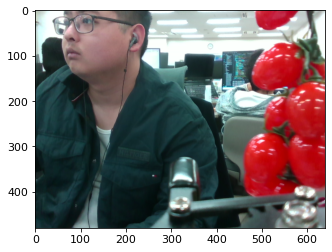

In [31]:
frames = pipeline.wait_for_frames()
aligned_frames = align.process(frames)
aligned_depth_frame = aligned_frames.get_depth_frame()
color_frame = aligned_frames.get_color_frame()
depth_image = np.asanyarray(aligned_depth_frame.get_data())
color_image = np.asanyarray(color_frame.get_data())
depth_colormap = cv2.applyColorMap(cv2.convertScaleAbs(depth_image, alpha=0.03), cv2.COLORMAP_JET)
# images = np.hstack((color_image, depth_colormap))
# images = cv2.cvtColor(images, cv2.COLOR_RGB2BGR)
color_image = cv2.cvtColor(color_image, cv2.COLOR_RGB2BGR)
plt.imshow(color_image)
plt.show()

In [ ]:
from matplotlib import pyplot as plt
def detect(save_img=False):
    out, source, weights, view_img, save_txt, imgsz = 'inference/output', '0', '/home/jetson/code/yolov5/yolov5-3.0/1105.pt', True, True, 320
    webcam = source == '0' or source.startswith('rtsp') or source.startswith('http') or source.endswith('.txt')

    # Initialize
    set_logging()
    device = select_device('')
    if os.path.exists(out):
        shutil.rmtree(out)  # delete output folder
    os.makedirs(out)  # make new output folder
    half = device.type != 'cpu'  # half precision only supported on CUDA

    # Load model
    model = attempt_load(weights, map_location=device)  # load FP32 model
    imgsz = check_img_size(imgsz, s=model.stride.max())  # check img_size
    if half:
        model.half()  # to FP16

    # Second-stage classifier
    classify = False
    if classify:
        modelc = load_classifier(name='resnet101', n=2)  # initialize
        modelc.load_state_dict(torch.load('weights/resnet101.pt', map_location=device)['model'])  # load weights
        modelc.to(device).eval()


    # Get names and colors
    names = model.module.names if hasattr(model, 'module') else model.names
    colors = [[random.randint(0, 255) for _ in range(3)] for _ in range(len(names))]

    # Run inference
    t0 = time.time()
    img = torch.zeros((1, 3, imgsz, imgsz), device=device)  # init img
    _ = model(img.half() if half else img) if device.type != 'cpu' else None  # run once
    return model
  
def one_step(model,pipeline,names,img_save=True):
    
    frames = pipeline.wait_for_frames()
    aligned_frames = align.process(frames)
    aligned_depth_frame = aligned_frames.get_depth_frame()
    color_frame = aligned_frames.get_color_frame()
    depth_image = np.asanyarray(aligned_depth_frame.get_data())
    color_image = np.asanyarray(color_frame.get_data())
    depth_colormap = cv2.applyColorMap(cv2.convertScaleAbs(depth_image, alpha=0.03), cv2.COLORMAP_JET)
    # images = np.hstack((color_image, depth_colormap))
    # images = cv2.cvtColor(images, cv2.COLOR_RGB2BGR)
    color_image = cv2.cvtColor(color_image, cv2.COLOR_RGB2BGR)

    device = select_device('')
    # path, img, im0s, vid_cap = LoadStreams(source, img_size=320)
    
    img = torch.tensor(color_image)
    print(img.shape)
    img = np.transpose(img, (2, 0, 1))
    print(img.dtype)
    half = device.type != 'cpu'  # half precision only supported on CUDA
    img = img.half() if half else img.float()  # uint8 to fp16/32
    print(img.dtype)
    img /= 255.0  # 0 - 255 to 0.0 - 1.0
    if img.ndimension() == 3:
        img = img.unsqueeze(0)
    
    print(img.shape)
    img = img.to(device)
    # Inference
    t1 = time_synchronized()
    pred = model(img, augment=True)[0]

    # Apply NMS
    pred = non_max_suppression(pred, 0.7, 0.6, classes=None, agnostic=True)
    t2 = time_synchronized()

    # Process detections
    img = np.array(img.squeeze(0).cpu())
    img = np.transpose(img, (1, 2, 0))
    img = img * 255
    img = img.astype(np.uint8)
    for i, det in enumerate(pred):  # detections per image
        # Print time (inference + NMS)
        print('Done. ({:.3f}s)'.format((t2 - t1)))    
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    if det is not None:
        for *xyxy, conf, cls in reversed(det):
            label = '%s %.2f' % (names[int(cls)], conf)
            print(xyxy)
            plot_one_box(xyxy, img, label=label, line_thickness=3)
    img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
    plt.imshow(img)
    plt.show()
    if img_save:
        img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
        cv2.imwrite("a.png",img)
    return det


# def one_step(model,cap,names,img_save=True):

#     # 检查摄像头是否成功打开
#     if not cap.isOpened():
#         print("无法打开摄像头")
#         exit()

#     # 读取一帧
#     ret, frame = cap.read()
#     frame = frame[:, :, ::-1].transpose(2, 0, 1).copy()
#     print("拍摄完成")

#     device = select_device('')
#     # path, img, im0s, vid_cap = LoadStreams(source, img_size=320)
    
#     img = torch.from_numpy(frame).to(device)
    
#     print(img.dtype)
#     half = device.type != 'cpu'  # half precision only supported on CUDA
#     img = img.half() if half else img.float()  # uint8 to fp16/32
#     print(img.dtype)
#     img /= 255.0  # 0 - 255 to 0.0 - 1.0
#     if img.ndimension() == 3:
#         img = img.unsqueeze(0)
    
#     print(img.shape)
#     # Inference
#     t1 = time_synchronized()
#     pred = model(img, augment=True)[0]

#     # Apply NMS
#     pred = non_max_suppression(pred, 0.7, 0.6, classes=None, agnostic=True)
#     t2 = time_synchronized()

#     # Process detections
#     img = np.array(img.squeeze(0).cpu())
#     img = np.transpose(img, (1, 2, 0))
#     img = img * 255
#     img = img.astype(np.uint8)
#     for i, det in enumerate(pred):  # detections per image
#         # Print time (inference + NMS)
#         print('Done. ({:.3f}s)'.format((t2 - t1)))    
#     img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
#     if det is not None:
#         for *xyxy, conf, cls in reversed(det):
#             label = '%s %.2f' % (names[int(cls)], conf)
#             print(xyxy)
#             plot_one_box(xyxy, img, label=label, line_thickness=3)
#     img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
#     plt.imshow(img)
#     plt.show()
#     if img_save:
#         img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
#         cv2.imwrite("a.png",img)
#     return det

In [ ]:
names = ['stem','tomato']
det = one_step(model,cap,names)

In [ ]:
model = detect()
# cap = cv2.VideoCapture(0)
cap = pipeline

In [ ]:
import numpy as np

def estimate_object_position(K, object_real_size, object_pixel_size, object_center):
    """
    推测物体在相机坐标系中的位置。

    参数：
        K (numpy.array): 相机内参矩阵 (3x3)。
        object_real_size (tuple): 物体的实际宽度和高度 (W_real, H_real)，单位为米或厘米。
        object_pixel_size (tuple): 物体在图像中的像素宽度和高度 (W_pixel, H_pixel)。
        object_center (tuple): 物体在图像中的中心像素坐标 (u, v)。

    返回：
        numpy.array: 物体的相机坐标 (X, Y, Z)。
    """
    # 解构内参矩阵
    fx = K[0, 0]
    fy = K[1, 1]
    cx = K[0, 2]
    cy = K[1, 2]

    # 解构输入参数
    W_real, H_real = object_real_size
    W_pixel, H_pixel = object_pixel_size
    u, v = object_center

    # 估算深度 Z（使用宽度计算）
    Z = (fx * W_real) / W_pixel 
    

    # 估算 X 和 Y 坐标
    X = ((u - cx) * Z) / fx
    Y = ((v - cy) * Z) / fy
    #补偿高度
    return np.array([X, Z, -Y])

interior_matrix = np.array([
    [1047.5, 0, 209.09],
    [0, 1049.3, 288.76],
    [0, 0, 1]
])


In [ ]:
import numpy as np

def euler_to_rotation_matrix(yaw, pitch, roll):
    """
    将欧拉角（yaw, pitch, roll）转换为旋转矩阵。
    
    参数：
        yaw (float): 绕 Z 轴的旋转角（弧度）
        pitch (float): 绕 Y 轴的旋转角（弧度）
        roll (float): 绕 X 轴的旋转角（弧度）
    
    返回：
        numpy.array: 3x3 旋转矩阵
    """
    R_yaw = np.array([
        [np.cos(yaw), -np.sin(yaw), 0],
        [np.sin(yaw), np.cos(yaw), 0],
        [0, 0, 1]
    ])
    R_pitch = np.array([
        [np.cos(pitch), 0, np.sin(pitch)],
        [0, 1, 0],
        [-np.sin(pitch), 0, np.cos(pitch)]
    ])
    R_roll = np.array([
        [1, 0, 0],
        [0, np.cos(roll), -np.sin(roll)],
        [0, np.sin(roll), np.cos(roll)]
    ])
    return R_yaw @ R_pitch @ R_roll

def camera_to_world(P_cam, T_cam, R_cam):
    """
    将相机坐标系下的点转换为世界坐标系。
    
    参数：
        P_cam (numpy.array): 相机坐标系下的点 (3x1)。
        T_cam (numpy.array): 相机在世界坐标系中的位置 (3x1)。
        R_cam (numpy.array): 相机的旋转矩阵 (3x3)。
    
    返回：
        numpy.array: 世界坐标系下的点 (3x1)。
    """
    P_world = R_cam @ P_cam + T_cam
    return P_world

In [ ]:
# 计算并将夹点运动到番茄位置
# 需解决：1. 如何确定夹点的前后 2. 如何选择目标
#'


cam_angle = 0
grab_size = 200*300
pick_coor = [240,300]
def calculate_frame_coor(det):
    res = []
    for i,(*xyxy, conf, cls) in enumerate(det):
        # 现在只抓番茄
        if cls == 1:
            x = int(xyxy[2]-xyxy[0])
            y = int(xyxy[3]-xyxy[1])
            c_x = int((xyxy[0]+ xyxy[2])/2)
            c_y = int((xyxy[1]+ xyxy[3])/2)
        res.append([i,c_x,c_y,x,y,conf,cls])
    return res



def select_tomato():
    # 根据坐标计算得分并选择番茄

    pass

# def calculate_distance(actual_width_cm, bbox_width_pixels):
#     """
#     根据目标检测框的宽度计算物体距离。
    
#     参数：
#         actual_width_cm (float): 物体的实际宽度，单位为 cm
#         bbox_width_pixels (float): 检测框的宽度，单位为像素
    
#     返回：
#         float: 估算的物体距离，单位为 cm
#     """
    
#     distances = np.array([15, 10, 5, 3, 1])  # 单位：cm
#     pixels_per_cm = np.array([33, 45, 60, 70, 90])  # 每厘米的像素数
#     f, _ = np.polyfit(1 / distances, pixels_per_cm, 1)
#     distance_cm = (actual_width_cm * f) / bbox_width_pixels
#     return distance_cm

# def calculate_world_coor(coor_list, pick_coor,cam_angle,grab_size=60000,actual_width_cm=3.5):
#     # 计算距离,现在临时使用分段函数插值计算,之后使用深度相机值
#     for i,c_x,c_y,x,y,conf,cls in coor_list:
#         # # 计算离夹点最近的番茄并打分
#         # size = x*y
#         # if size >= 30000:
#         #     distance = (10-size/7000)
#         # else:
#         #     distance = (5-(size-30000)/2000)
#         # drift = np.linalg.norm([x-pick_coor[0],y-pick_coor[1]],ord=2)
#         # score = 1/distance + drift
        
#         estimated_distance = calculate_distance(actual_width_cm, x)


#         print(f"{i}th,distance:{estimated_distance}")
#         print(f"center_x:{c_x},center_y:{c_y}\nx:{x},y:{y}")
#     # 按照相机角度,距离和xy值计算下一步坐标
#     cam_accumu_angle = 0  
#     # 如果可以直接抓那就直接抓(返回抓取
coor_list = calculate_frame_coor(det)
print(coor_list)

In [ ]:
object_real_size = (0.033, 0.037)  # 物体实际宽度和高度 (单位：米)
coor_list = calculate_frame_coor(det)
object_pixel_size = (coor_list[0][4], coor_list[0][5])   # 物体在图像中的像素宽度和高度
object_center = (coor_list[0][1], coor_list[0][2])       # 物体在图像中的中心像素坐标
interior_matrix = np.array([
    [1047.5, 0, 209.09],
    [0, 1049.3, 288.76],
    [0, 0, 1]
])
object_position = estimate_object_position(interior_matrix, object_real_size, object_pixel_size, object_center)
print(object_position)
camera_position, camera_pitch_angle, camera_yaw_angle = calculate_camera(length)
camera_para = [camera_position,camera_pitch_angle,camera_yaw_angle]
print(camera_para)
print(np.degrees(camera_pitch_angle))
T_cam,roll,yaw=camera_para
pitch = 0
P_cam = object_position
# 计算旋转矩阵
R_cam = euler_to_rotation_matrix(yaw, pitch, roll)

# 将相机坐标系的点转换为世界坐标系
P_world = camera_to_world(P_cam, T_cam, R_cam)
print(P_world)
print("物体在世界坐标系中的位置:", P_world)


In [ ]:
import ikpy.chain
import numpy as np
# target_position = [0,11,9]
target_position = [-4,5,4]

target_position = [-15,15,-8]

converted_position = np.array(target_position) * -0.01
# converted_position = np.array(P_world) *-1
# my_chain = ikpy.chain.Chain.from_urdf_file("/home/jetson/code/yolov5/yolov5-3.0/arm_test.URDF")
my_chain = ikpy.chain.Chain.from_urdf_file("/home/jetson/code/yolov5/yolov5-3.0/arm copy.URDF")
joint_list = my_chain.inverse_kinematics(converted_position)[1:]
joint_deg_list = [int(x)+90 for x in np.degrees(joint_list[:-1])]
joint_deg_list.append(20)
print("The angles of each joints should be:" , joint_deg_list)

real_frame = my_chain.forward_kinematics(my_chain.inverse_kinematics(converted_position))
error = np.abs(np.linalg.norm(list(real_frame[:3,3]),ord=2)-np.linalg.norm(converted_position,ord=2))
print("{:.2f}%".format(error*100))
print("The position is:\n", real_frame)
if "{:.2f}%".format(error*100) != "0.00%":
    print("out of range")
else:
    servo_write(joint_deg_list,1500) 

In [ ]:
names = ['stem','tomato']
det = one_step(model,cap,names)

import cv2
import numpy as np

# 定义棋盘格大小（行和列的交点数量）
checkerboard_size = (9, 6)  # 例如，7x6 的棋盘格

# 定义每个方格的大小（单位：米或厘米，需根据标定板实际尺寸）
square_size = 2.6  # 例如 1 cm

# 准备棋盘格的3D点
objp = np.zeros((checkerboard_size[0] * checkerboard_size[1], 3), np.float32)
objp[:, :2] = np.mgrid[0:checkerboard_size[0], 0:checkerboard_size[1]].T.reshape(-1, 2) * square_size

# 存储3D点和2D点
objpoints = []  # 存储3D点（真实世界坐标）
imgpoints = []  # 存储2D点（图像平面坐标）

# 读取标定图像
images = ["/home/jetson/code/2024-11-17-143909.jpg","/home/jetson/code/2024-11-08-102123.jpg","/home/jetson/code/2024-11-08-102134.jpg","/home/jetson/code/2024-11-08-102140.jpg","/home/jetson/code/2024-11-08-102146.jpg","/home/jetson/code/2024-11-08-102152.jpg"]  # 标定图像路径列表

for fname in images:
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # 找到棋盘格角点
    ret, corners = cv2.findChessboardCorners(gray, checkerboard_size, None)
    print(ret,corners)
    if ret:
        objpoints.append(objp)
        imgpoints.append(corners)

# 相机标定
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)

# 提取焦距
fx = mtx[0, 0]  # 焦距 fx
fy = mtx[1, 1]  # 焦距 fy
print("焦距 fx:", fx)
print("焦距 fy:", fy)
print("相机内参矩阵:\n", mtx)
mtx

In [ ]:
# del Arm  